In [2]:
import sys
import math
sys.path.insert(0, r'/home/danis/work/python_works/gamma_4/Scripts')
sys.path.insert(0, r'D:\Учеба\Практика\Диплом\gamma_4\Scripts')
import numpy as np
import pandas as pd
from materials import*
import matplotlib.pyplot as plt

Минимальная энергия: 1e-3
windows (w) or linux (l): w


In [3]:
m = 50

# Параметры пучка электронов и мишени
target = R(Material(m), 1e-2)
beams_energy = 0.075
brem = target.brem(beams_energy)
brem_e = brem * en

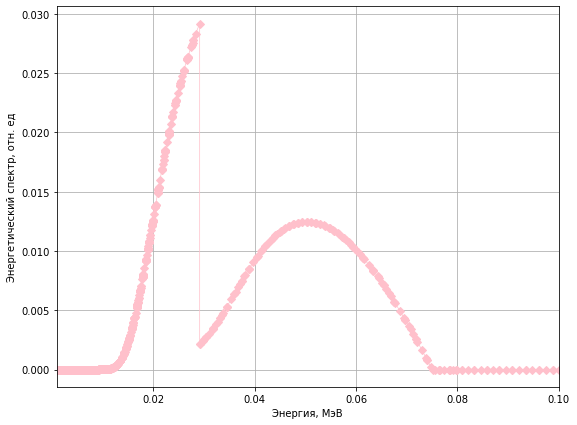

In [4]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(en, brem_e, ls='-', marker='D', lw='0.7', ms=5, color='pink')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.10e0)
# ax.set_ylim(1e-7, 1.2)

ax.grid(True)

# fig.savefig('Тормозной спектр.jpg', bbox_inches='tight')

In [5]:
n = 11

In [6]:
# Индексы К скачков
EDGE = []
for i in range(1, len(en)):
    if en[i - 1] == en[i]:
        EDGE.append(i - 1)

In [7]:
EDGE.remove(EDGE[EDGE.index(Material(m).k_index())])

Спектральные характеристики чувствительности каналов

In [8]:
def ross_by_k_level(num_1, num_2, level):
    t_2 = Material(num_2).lt(level)
    f_2 = R(Material(num_2), Material(num_2).lt(level)).f()
    t_1 = Material(num_1).lt(R(Material(num_2), Material(num_2).lt(level)).f()[Material(num_1).k_index()])
    f_1 = R(Material(num_1), t_1).f()
    return f_2 - f_1

In [9]:
resp_ross = [ross_by_k_level(i, i+1, 0.1) for i in range(n, 100)]

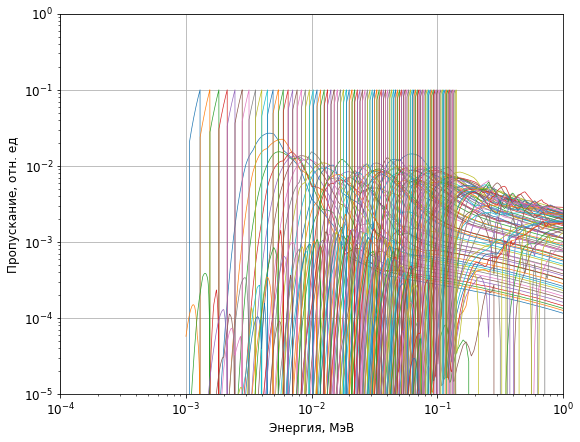

In [10]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in resp_ross:
    ax.plot(en, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Пропускание, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-4, 1e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

Сигналы детекторов

In [11]:
from garipov_deconvolution import get_coeff_simpson

In [12]:
signals_simpson = []

for response in resp_ross:
    signals_simpson.append(sum(get_coeff_simpson(response*brem_e, en, EDGE)[0]))

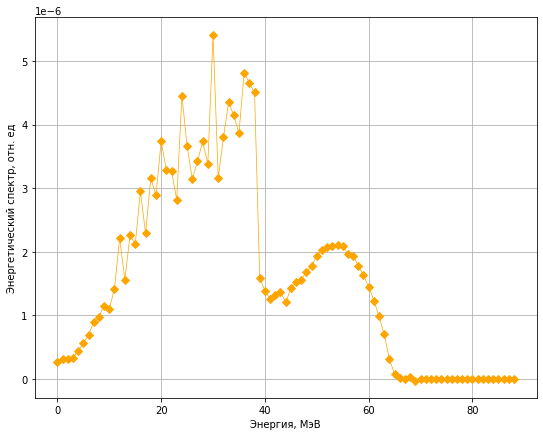

In [13]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(list(range(len(signals_simpson))), signals_simpson, ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1.e-5, 0.3e-4)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

Матрица задачи

In [18]:
Matrixs = []

for response in resp_ross:
    Matrixs.append(get_coeff_simpson(response, en, EDGE)[0])

In [19]:
from garipov_deconvolution import*

In [20]:
sp = [0 for i in range(len(signals_simpson))]
norm = [0 for i in range(len(signals_simpson))]
decb = [0 for i in range(len(signals_simpson))]
dev = [0 for i in range(len(signals_simpson))]

new_en = get_coeff_simpson(resp_ross[0], en, EDGE)[1]

In [375]:
import time

start_time = time.time()
sp, norm, dev = Gold(Matrixs, signals_simpson, en, brem_e, new_en, 1, 1000, w=True, d=False)[:3]
print(f'время: {time.time() - start_time}, секунд')

время: 0.41682004928588867, секунд


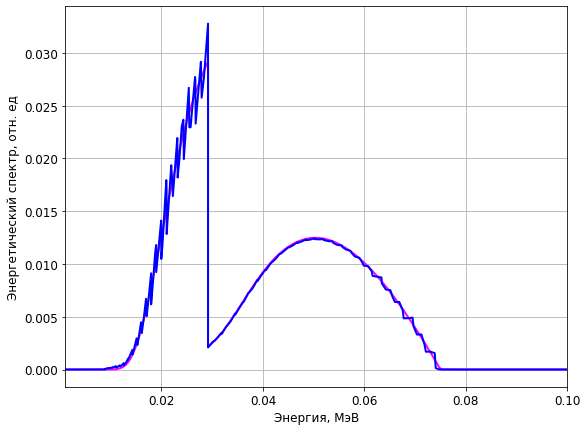

In [376]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(en, brem_e, ls='-', lw='2', ms=5, color='magenta')
ax.plot(new_en, sp, ls='-', lw='2', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

In [377]:
deviation(brem_e, sp, new_en)

0.0031290163640181955

In [318]:
def Gold2(A, b, en, init_spectrum, dec_en, x0=False, it=None, w=False, d=False):
	A = np.array(A)
	b = np.array(b)
	b = b.reshape(len(b), -1)

	# # Если начальное приближение не задано создает вектор-столбец x0 = [1, 1,.., 1]
	previous_x = np.array(x0)
	previous_x = previous_x.reshape(-1, 1)
# 	print(previous_x.shape)
		
	# Транспонирование вектора b, если он считывается вектором-строкой
	if b.shape[1] != 1:
		b = b.T
	if it is None:
		num_of_iter = int(input('Введите число итераций: '))
	else:
		num_of_iter = it

	if w == False:
		W = np.diag([float(1 ** 2) for i in range(0, len(b))])
	if w == True:
		W = np.diag([float(i) for i in range(0, len(b))])

	current_x = np.ones((A.shape[1], 1), dtype=np.float64)
	norm_list = []
	deviation_list = []

	# Основной цикл алгоритма Голда
	for k in range(0, num_of_iter + 1):
		# Создание матрицы Y = A.T * W.T * W * b
		Y = np.dot(A.T, np.dot(W.T, np.dot(W, b)))
		# Создание матрицы AX = A.T * W.T * W * A * x
		AX = np.dot(A.T, np.dot(W.T, np.dot(W, np.dot(A, previous_x))))
		AX[AX == 0] = np.nextafter(0, 1)*1e20
		current_x = 1.0 * previous_x + (previous_x / AX) * (Y - AX)
		previous_x = current_x
    
	current_x = current_x.reshape(1, -1)
	current_x = current_x[0].tolist()
	return current_x

In [331]:
def Gold_boost(R, L, p):
    r = 1
    x_0 = Gold2(Matrixs, signals_simpson, en, brem_e, new_en, x0=[1 for i in range(len(new_en))], it=L, w=True, d=False)
    for i in range(R):
        x_r = Gold2(Matrixs, signals_simpson, en, brem_e, new_en, x_0, L, w=True, d=False)
        print(i)
        x_0 = np.array(x_r)**p
    return x_r

In [370]:
sp2 = Gold_boost(100, 1000, 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


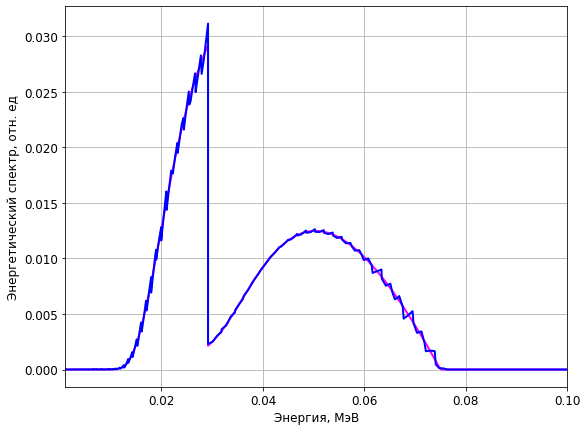

In [378]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(en, brem_e, ls='-', lw='2', ms=5, color='magenta')
ax.plot(new_en, sp2, ls='-', lw='2', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

In [379]:
def deviation(init_spectrum, dec_spectrum, dec_en):
		dec_spectrum_on_init_grid = np.interp(en, dec_en, dec_spectrum)
		different = [(i - j) ** 2 for i, j in zip(dec_spectrum_on_init_grid, init_spectrum)]
		init_sq = [val ** 2 for val in init_spectrum]

		def integral_t(different_signal, grid):
			s = 0
			for i in range(1, len(different_signal) - 2):
				s += (grid[i] - grid[i - 1]) * different_signal[i - 1]
			return s

		dev = integral_t(different, en) / integral_t(init_sq, en)
		return dev

In [380]:
deviation(brem_e, sp, new_en)

0.0031290163640181955

In [381]:
deviation(brem_e, sp2, new_en)

0.0007912637586710705